This notebook plots BDT variables' distribution in control region after split by whether the invariant mass of leading and subleading leptonJets > or < 50GeV.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import json

########## backgrounds ##########
bkgdatasets_=json.load(open('../../MC/Samples/backgrounds_nonempty.json'))
bkgscales_=json.load(open('../../MC/Samples/backgrounds_scale.json'))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        files = bkgdatasets_[group][tag]
        bkgdatasets[tag] = {'files': files, 'treename': 'ffNtuples/ffNtuple'}
        if tag=='TTJets': bkgdatasets[tag]['treename'] = 'ffNtuplizer/ffNtuple'

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 60.432*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open('../Samples/control_data2018.json'))
datadatasets = dict(
    A={'files': datadatasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'},
    B={'files': datadatasets_['B'], 'treename': 'ffNtuples/ffNtuple'},
    C={'files': datadatasets_['C'], 'treename': 'ffNtuples/ffNtuple'},
    D={'files': datadatasets_['D'], 'treename': 'ffNtuples/ffNtuple'},
)
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

In [6]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

In [7]:
# common plotting options

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [11]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        msplit_axis  = hist.Cat('ms', 'mass splitting by 50')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis, msplit_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, msplit_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, msplit_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, msplit_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, msplit_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, msplit_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, msplit_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, msplit_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, msplit_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, msplit_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, msplit_axis),
            "ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis, msplit_axis),
            "ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis, msplit_axis),
            "ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis, msplit_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, msplit_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()

        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
            leptonjets_ = dileptonjets[controlregion.flatten()]
            
            masscut = leadingLjPair[controlregion.flatten()].mass.flatten()<50
            leptonjets_ml = leptonjets_[masscut]  # mass-left
            leptonjets_mr = leptonjets_[~masscut] # mass-right

            output['pt'].fill(dataset=dataset, pt=leptonjets_ml.pt.flatten(), ms='left')
            output['eta'].fill(dataset=dataset, eta=leptonjets_ml.eta.flatten(), ms='left')
            output['nef'].fill(dataset=dataset, nef=leptonjets_ml.nef.flatten(), ms='left')
            output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_ml.maxd0.flatten(), ms='left')
            output['mind0'].fill(dataset=dataset, mind0=leptonjets_ml.mind0.flatten(), ms='left')
            output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_ml.tkiso.flatten(), ms='left')
            output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_ml.pfiso.flatten(), ms='left')
            output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_ml.spreadpt.flatten(), ms='left')
            output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_ml.spreaddr.flatten(), ms='left')
            output['lamb'].fill(dataset=dataset, lamb=leptonjets_ml.lamb.flatten(), ms='left')
            output['epsi'].fill(dataset=dataset, epsi=leptonjets_ml.epsi.flatten(), ms='left')
            output['ecfe1'].fill(dataset=dataset, ecfe1=leptonjets_ml.ecf1.flatten(), ms='left')
            output['ecfe2'].fill(dataset=dataset, ecfe2=leptonjets_ml.ecf2.flatten(), ms='left')
            output['ecfe3'].fill(dataset=dataset, ecfe3=leptonjets_ml.ecf3.flatten(), ms='left')
            output['mva'].fill(dataset=dataset, mva=leptonjets_ml.mva.flatten(), ms='left')
            
            output['pt'].fill(dataset=dataset, pt=leptonjets_mr.pt.flatten(), ms='right')
            output['eta'].fill(dataset=dataset, eta=leptonjets_mr.eta.flatten(), ms='right')
            output['nef'].fill(dataset=dataset, nef=leptonjets_mr.nef.flatten(), ms='right')
            output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_mr.maxd0.flatten(), ms='right')
            output['mind0'].fill(dataset=dataset, mind0=leptonjets_mr.mind0.flatten(), ms='right')
            output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_mr.tkiso.flatten(), ms='right')
            output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_mr.pfiso.flatten(), ms='right')
            output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_mr.spreadpt.flatten(), ms='right')
            output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_mr.spreaddr.flatten(), ms='right')
            output['lamb'].fill(dataset=dataset, lamb=leptonjets_mr.lamb.flatten(), ms='right')
            output['epsi'].fill(dataset=dataset, epsi=leptonjets_mr.epsi.flatten(), ms='right')
            output['ecfe1'].fill(dataset=dataset, ecfe1=leptonjets_mr.ecf1.flatten(), ms='right')
            output['ecfe2'].fill(dataset=dataset, ecfe2=leptonjets_mr.ecf2.flatten(), ms='right')
            output['ecfe3'].fill(dataset=dataset, ecfe3=leptonjets_mr.ecf3.flatten(), ms='right')
            output['mva'].fill(dataset=dataset, mva=leptonjets_mr.mva.flatten(), ms='right')
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [12]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5366/5366 [07:01<00:00, 12.23items/s]


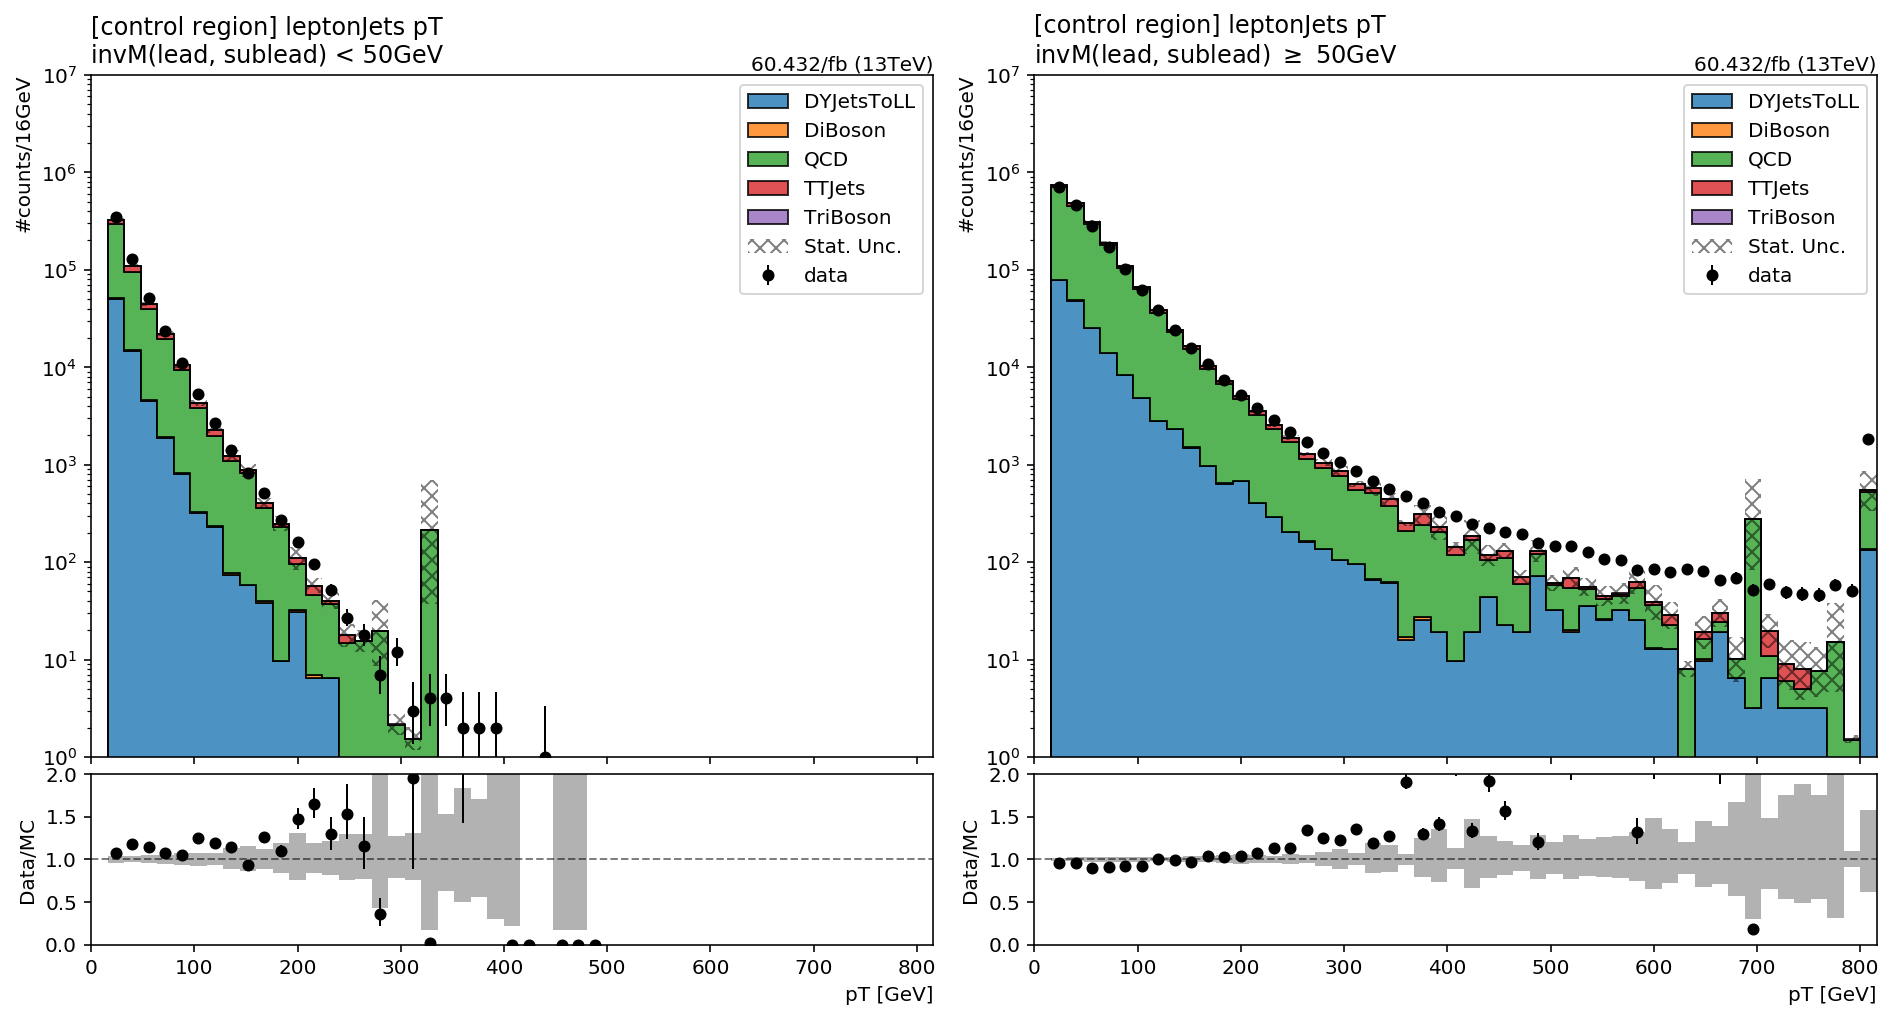

In [39]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['pt_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['pt_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['pt_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['pt_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['pt_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets pT \ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets pT \ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

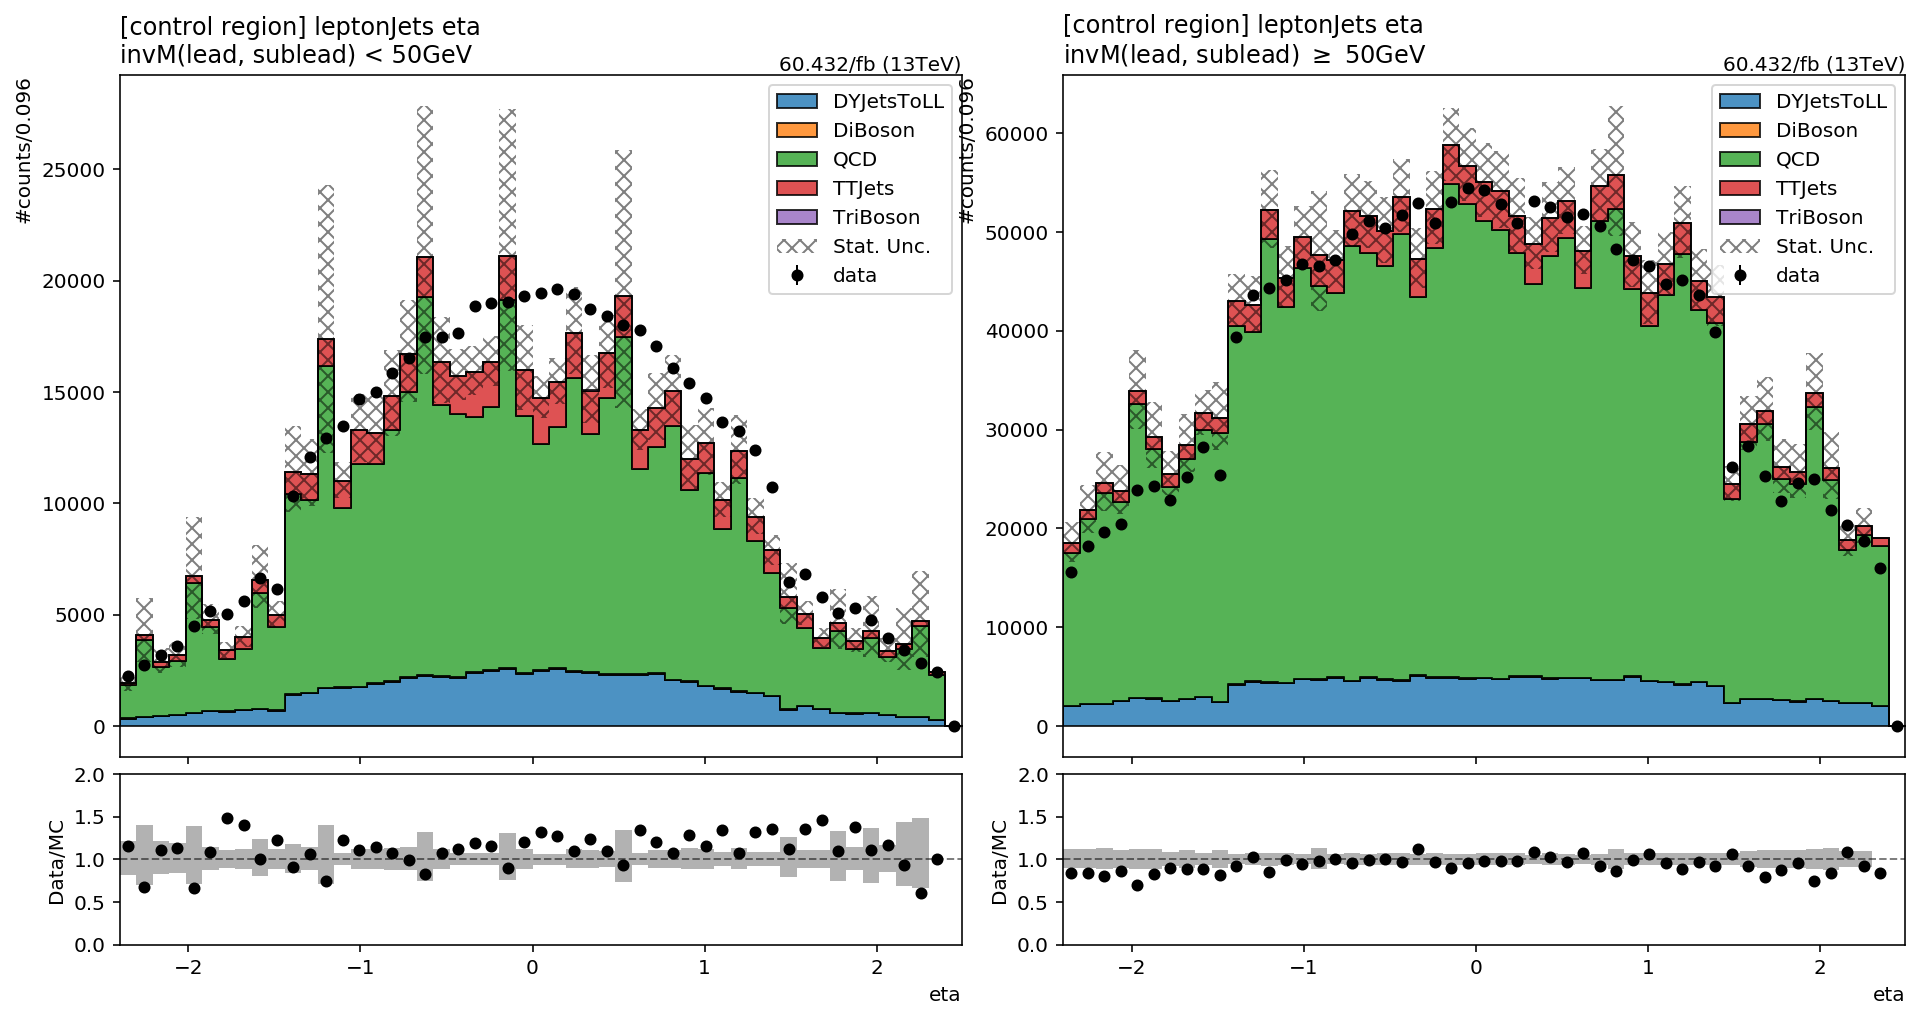

In [40]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['eta_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['eta_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['eta_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['eta_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['eta_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    # ax.set_yscale('log')
    # ax.set_ylim([1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets eta \ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets eta \ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

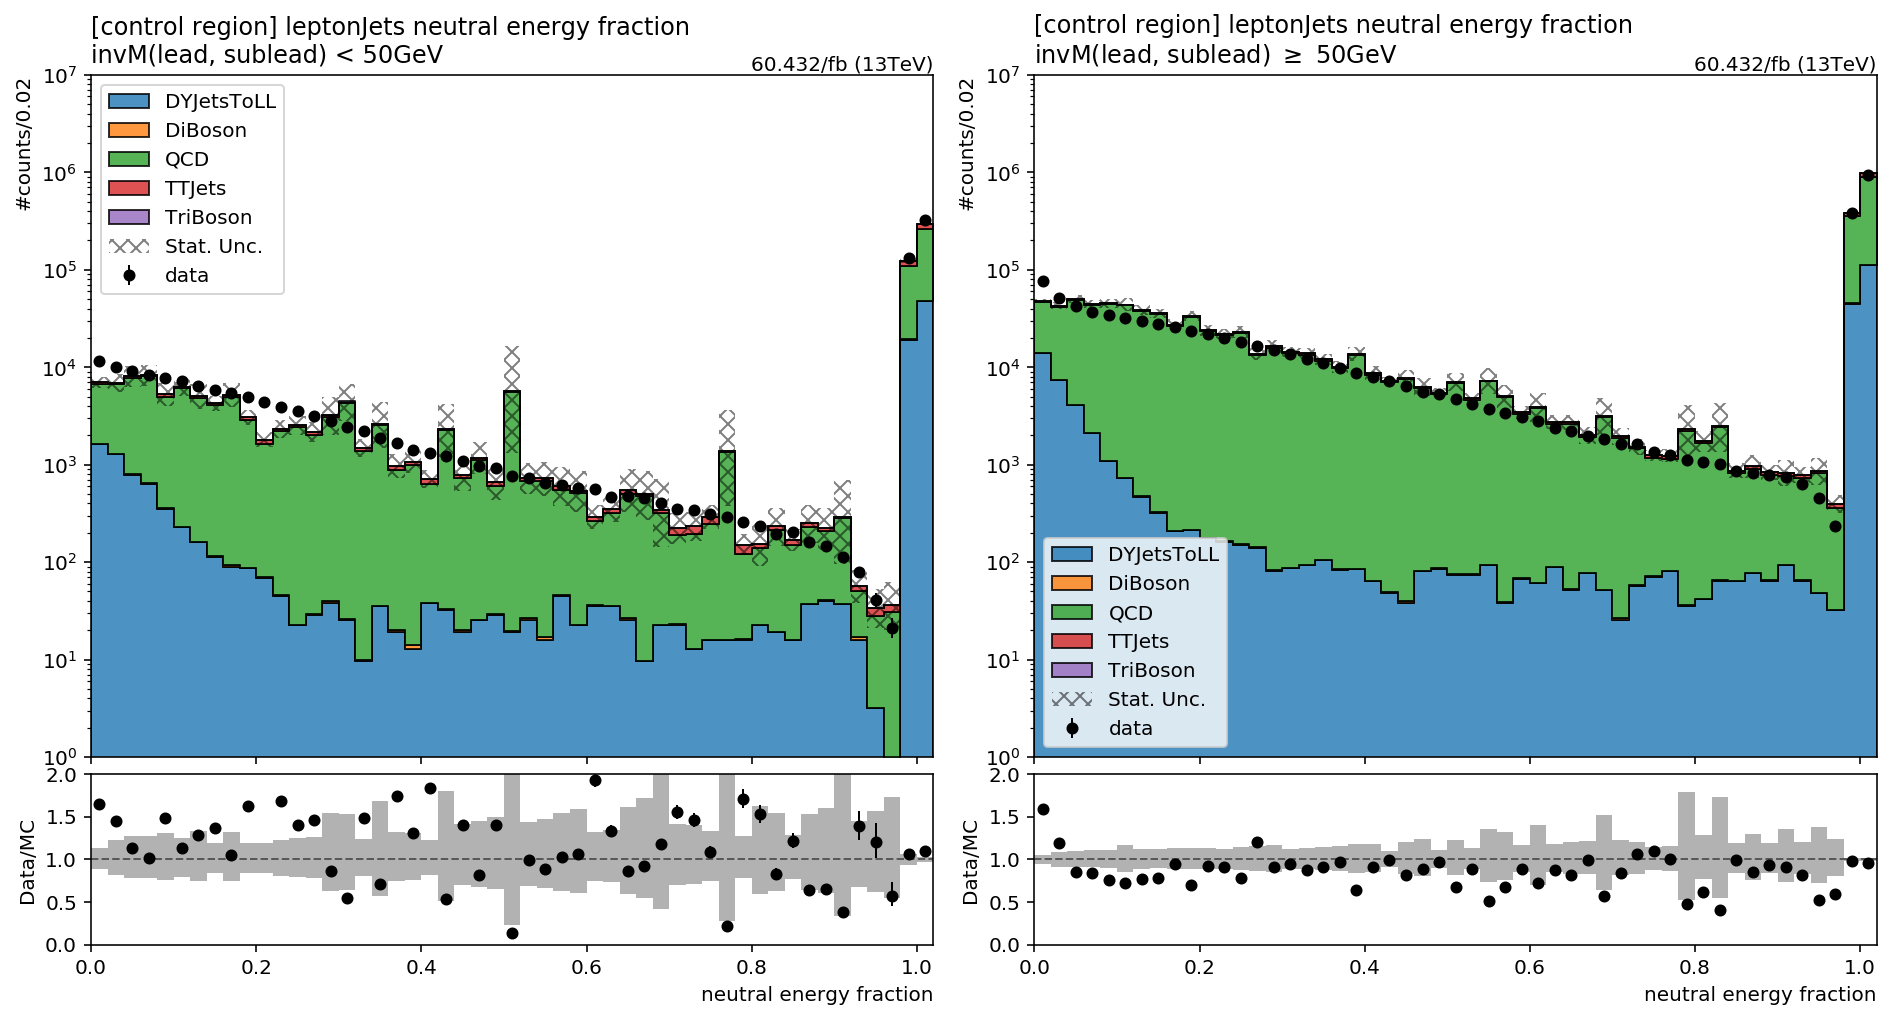

In [41]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['nef_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['nef_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['nef_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['nef_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['nef_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets neutral energy fraction \ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets neutral energy fraction \ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

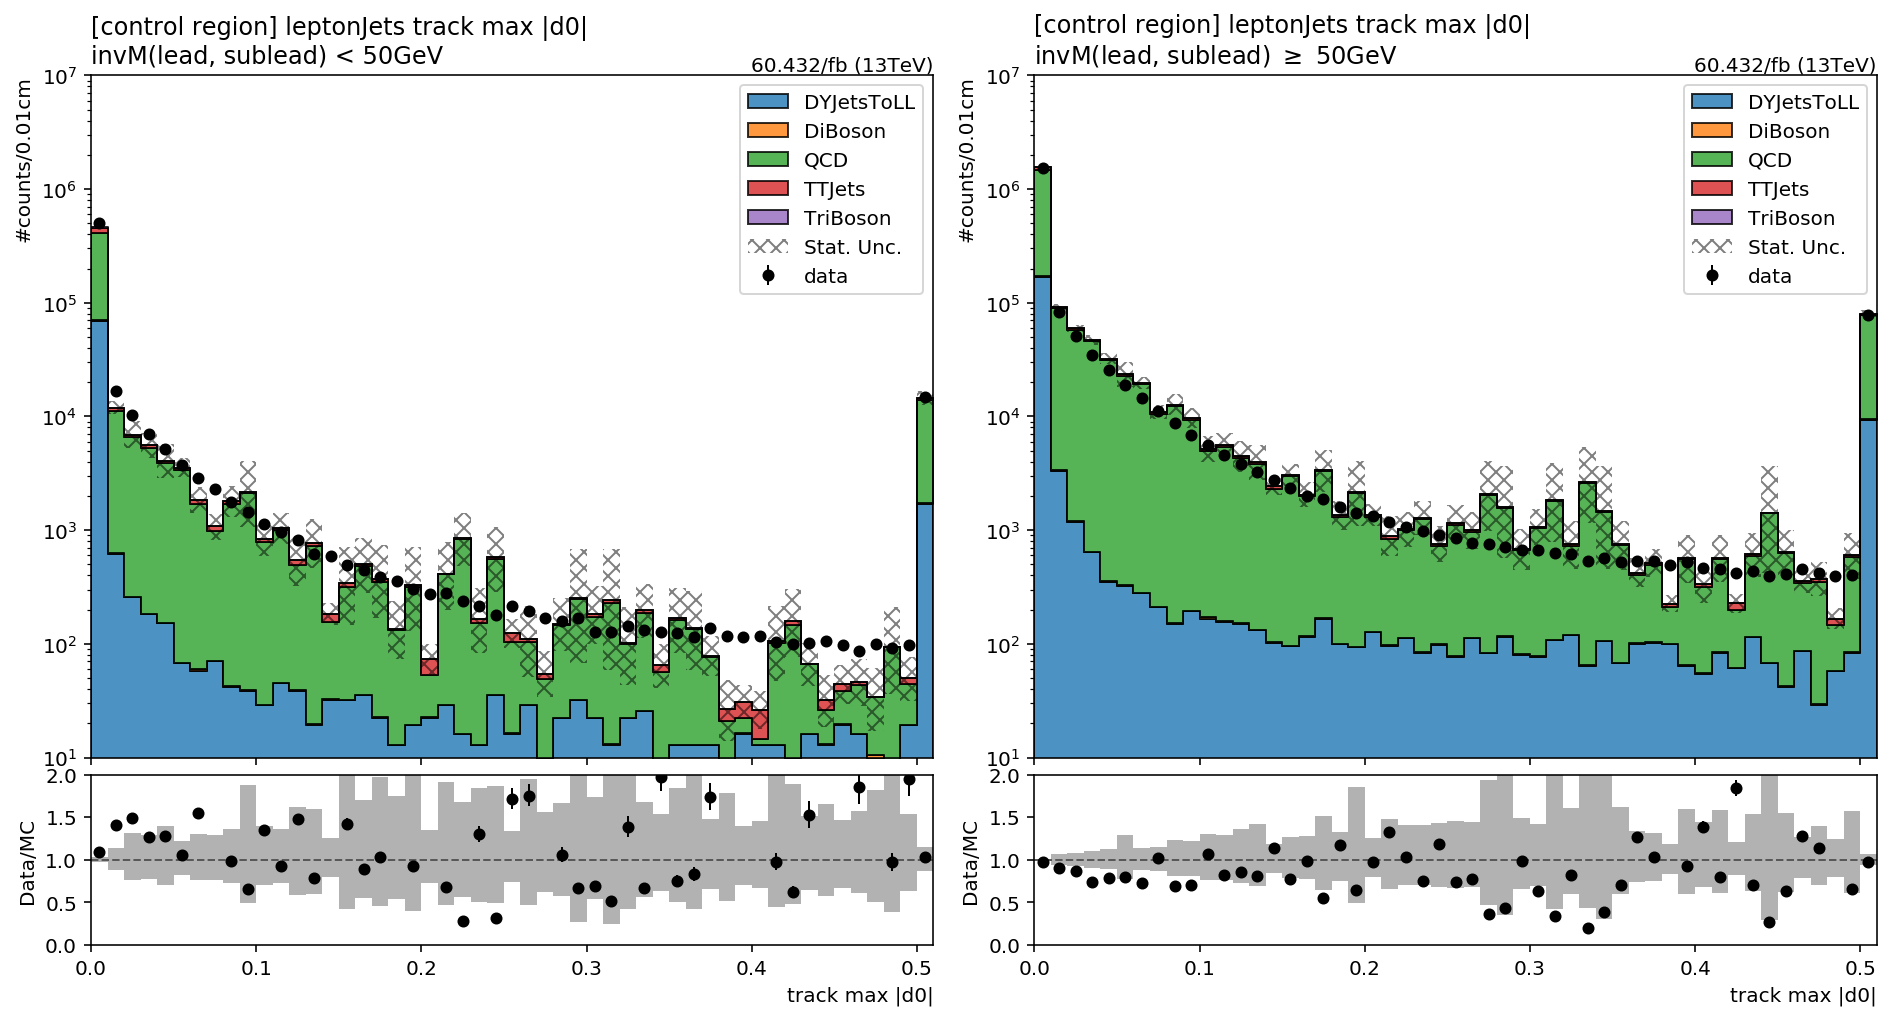

In [42]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['maxd0_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['maxd0_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['maxd0_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['maxd0_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['maxd0_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets track max |d0|\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets track max |d0|\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

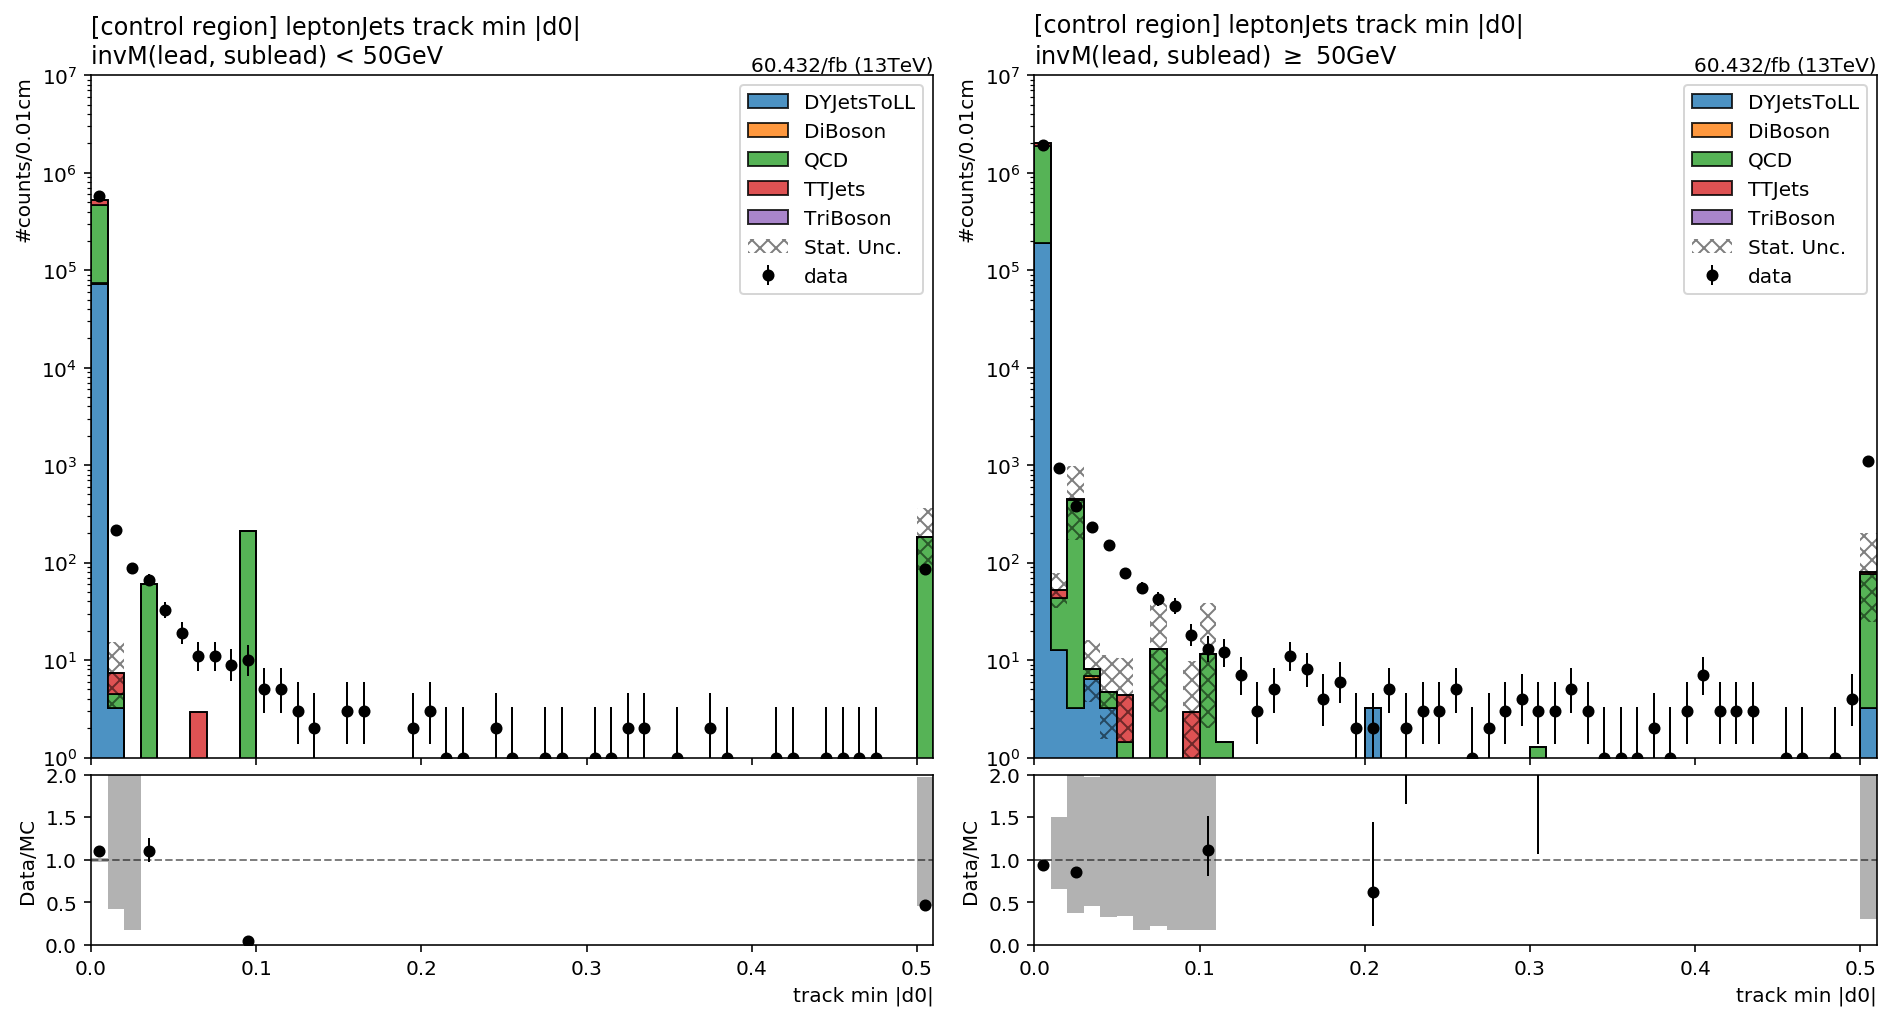

In [43]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['mind0_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['mind0_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['mind0_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['mind0_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['mind0_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets track min |d0|\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets track min |d0|\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

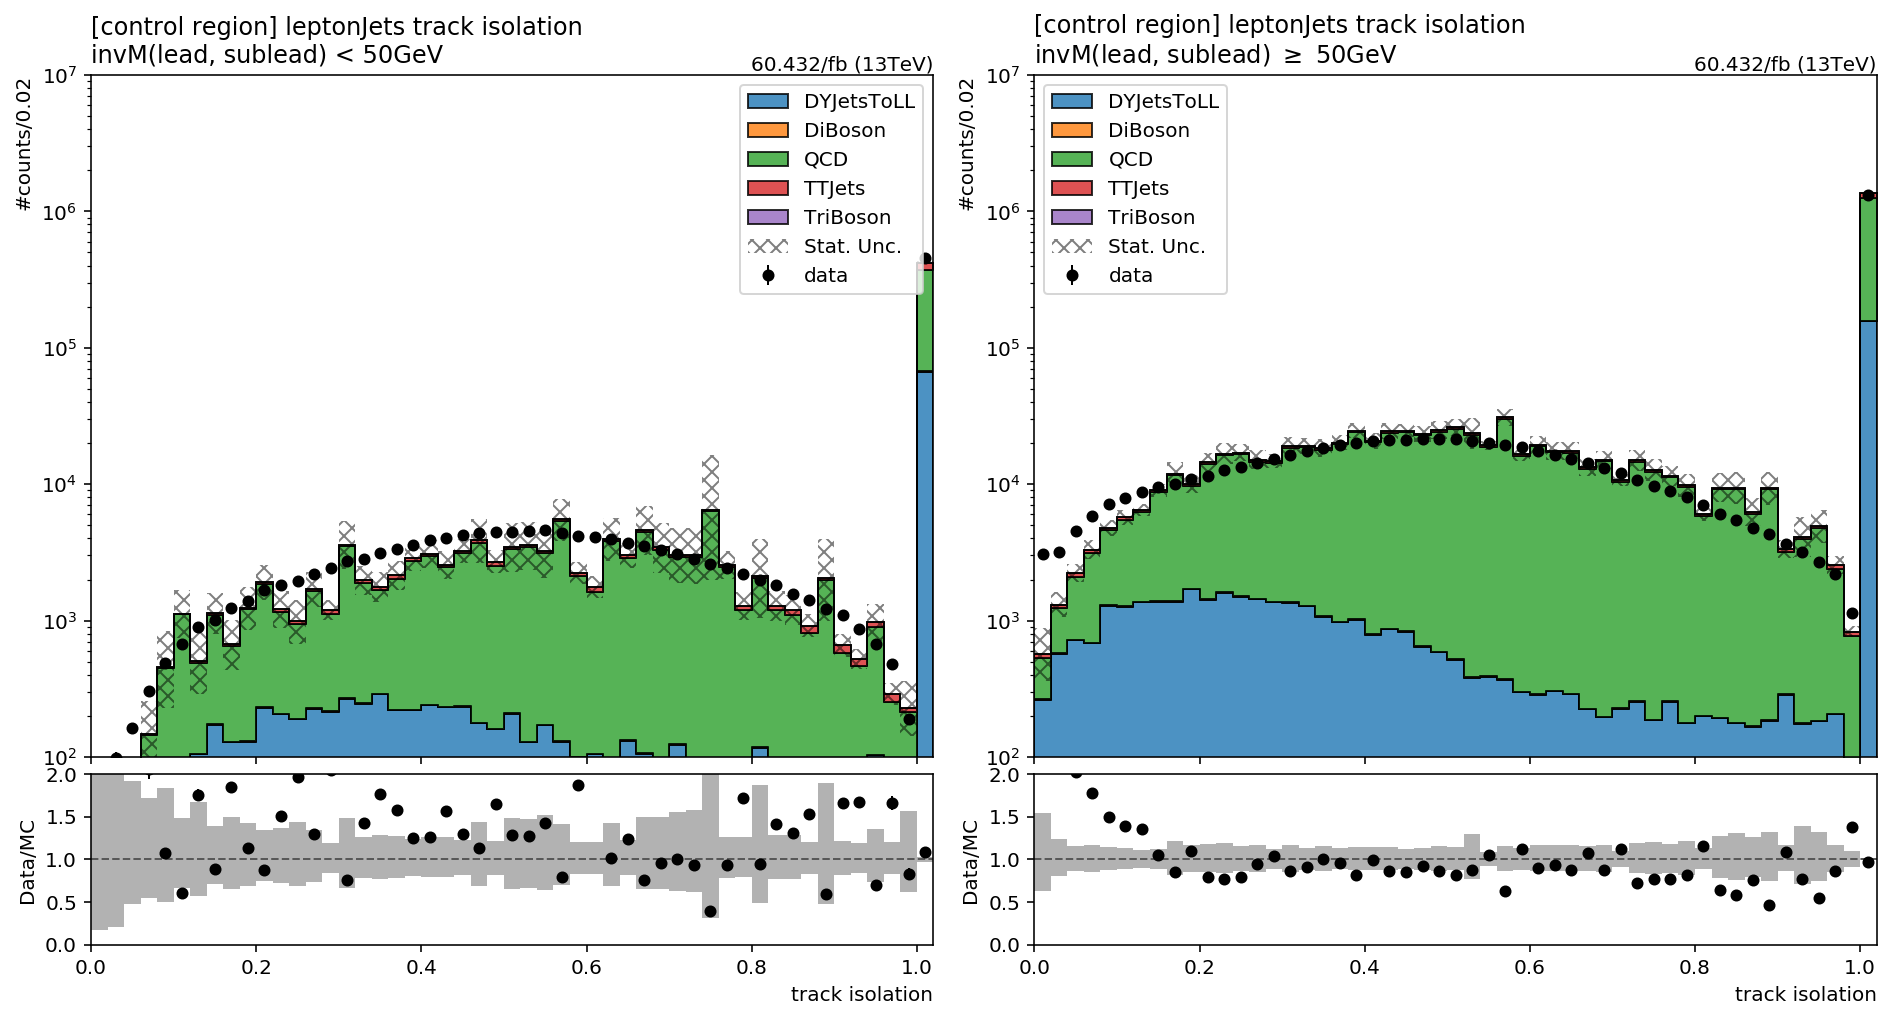

In [44]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['tkiso_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['tkiso_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['tkiso_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['tkiso_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['tkiso_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e2, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets track isolation\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets track isolation\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

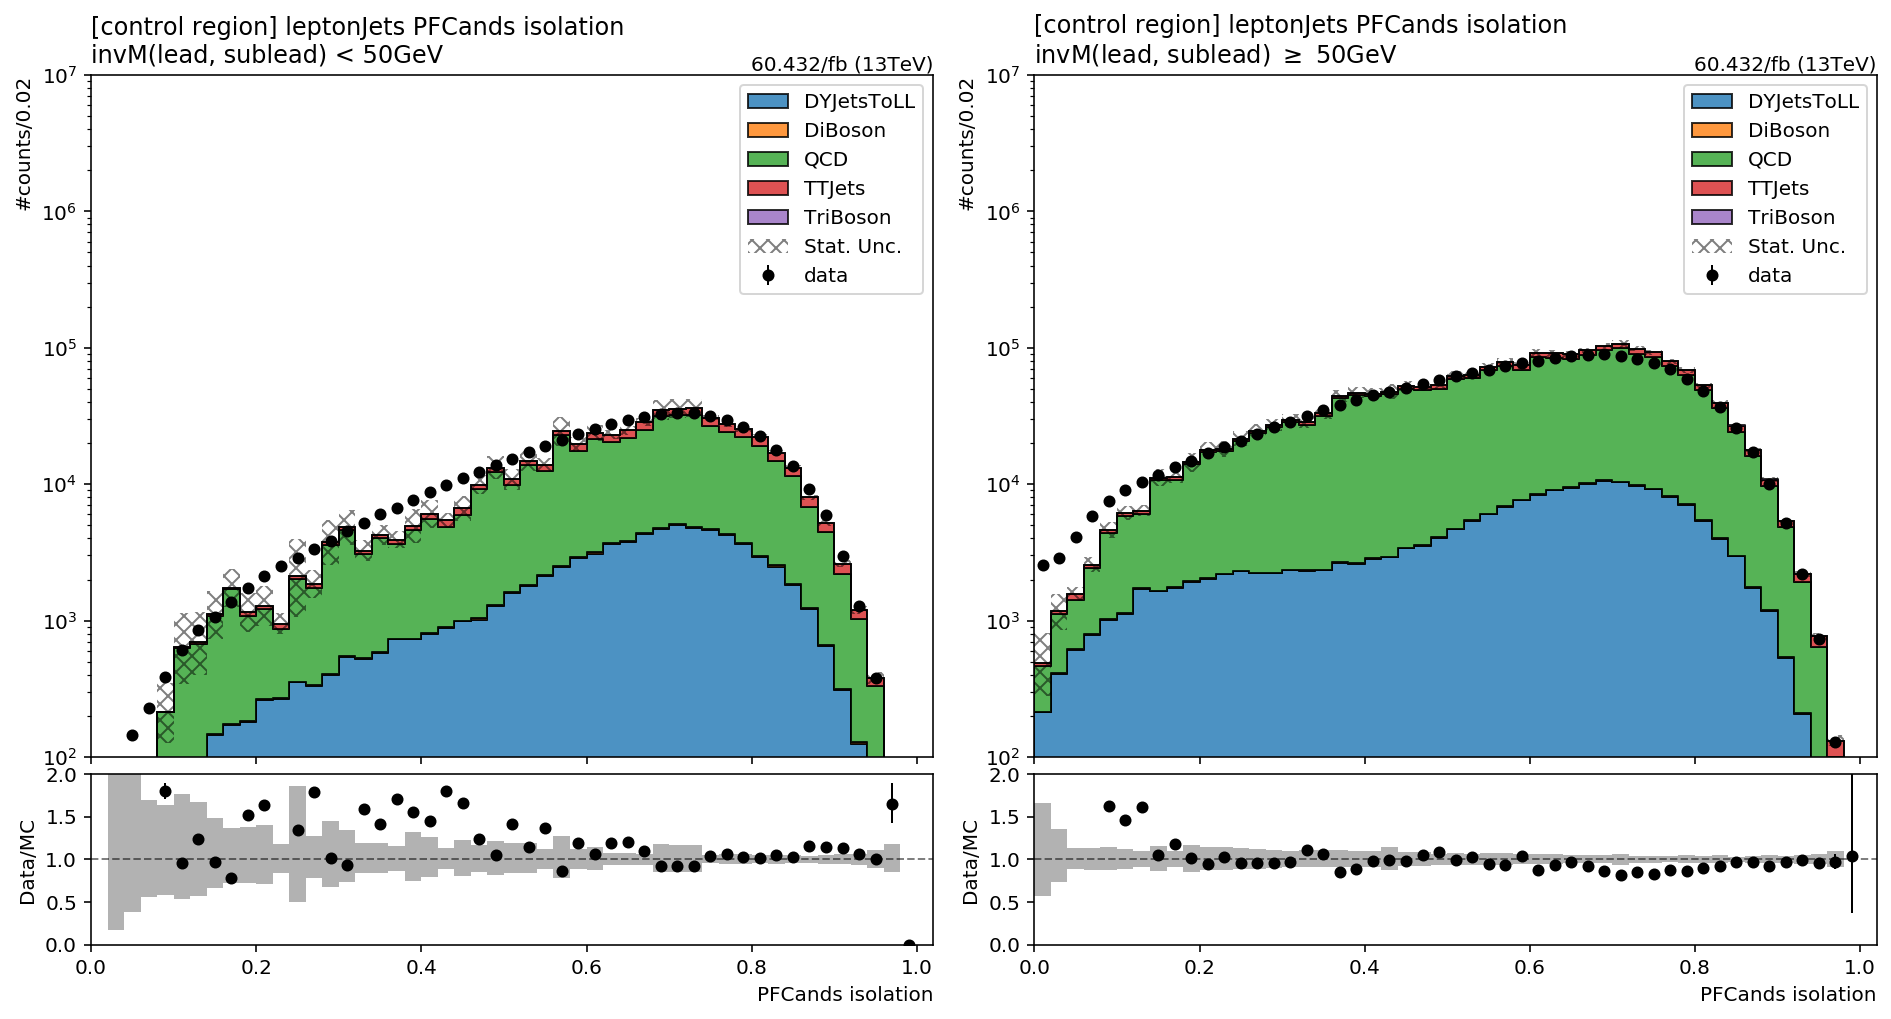

In [45]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['pfiso_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['pfiso_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['pfiso_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['pfiso_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['pfiso_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e2, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets PFCands isolation\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets PFCands isolation\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

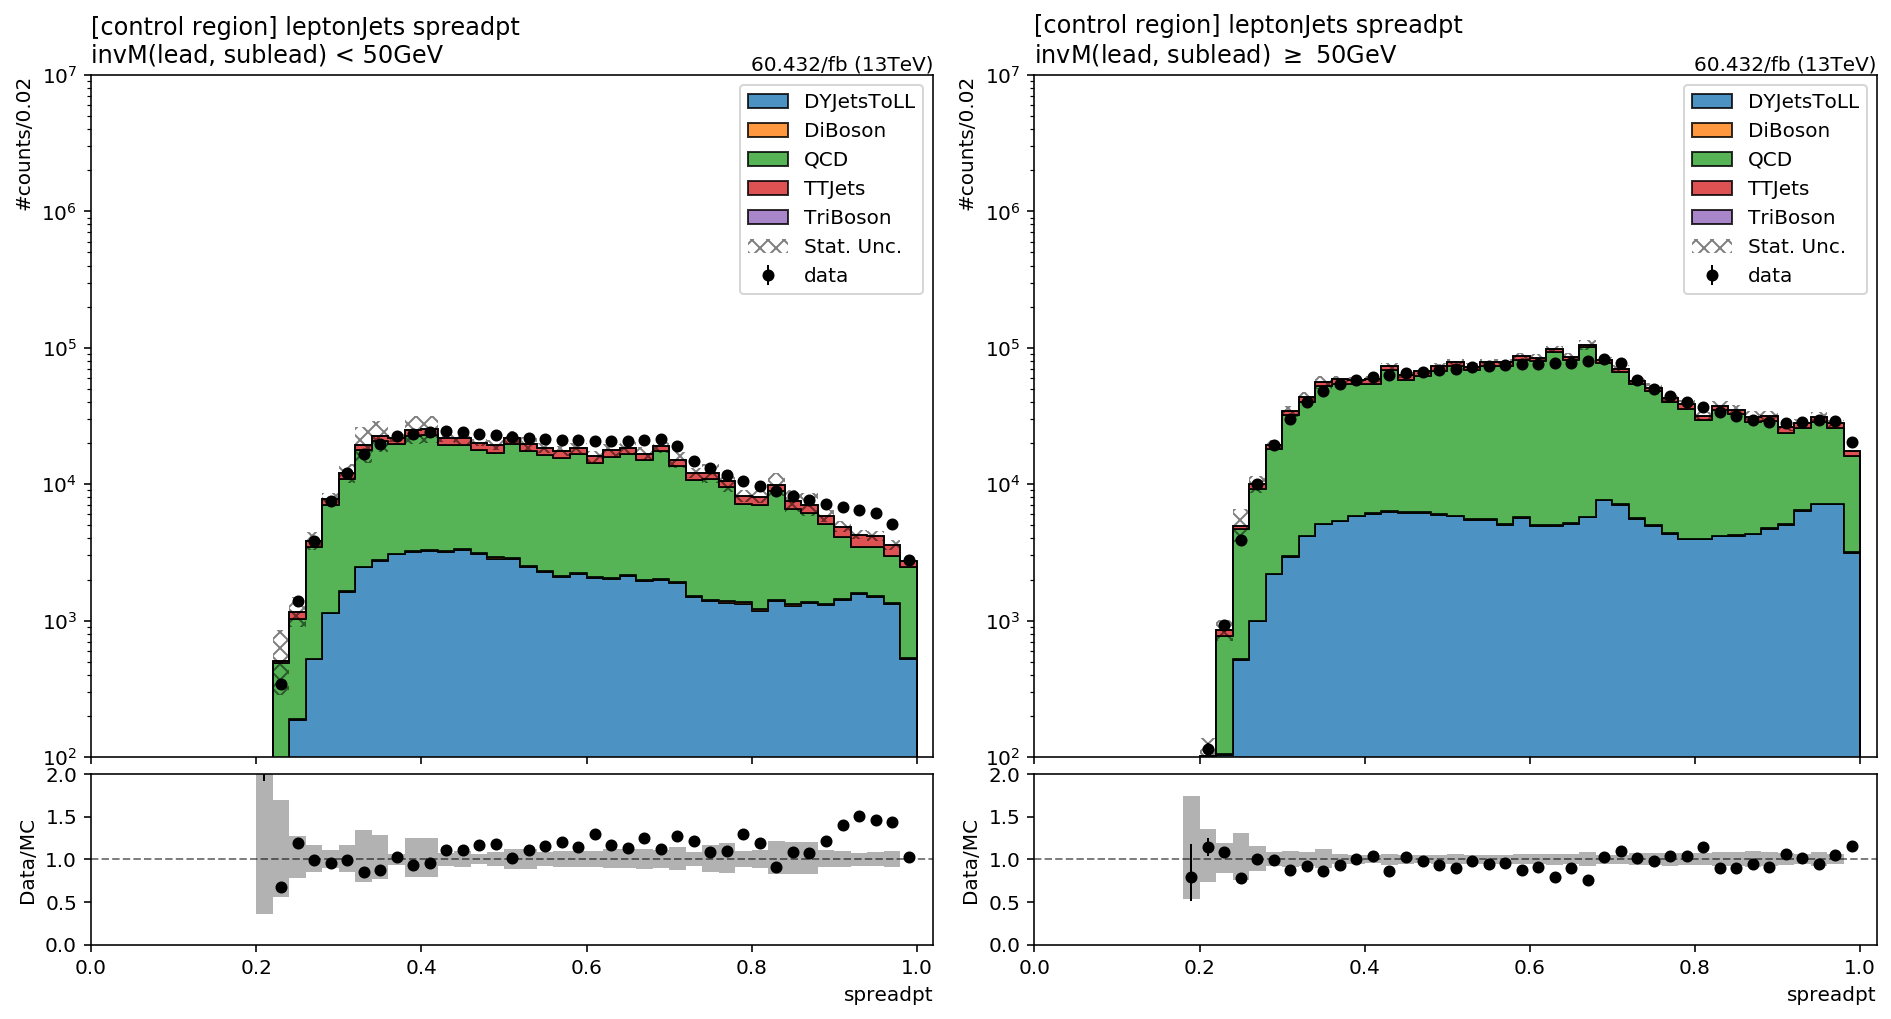

In [46]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['spreadpt_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['spreadpt_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['spreadpt_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['spreadpt_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['spreadpt_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e2, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets spreadpt\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets spreadpt\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

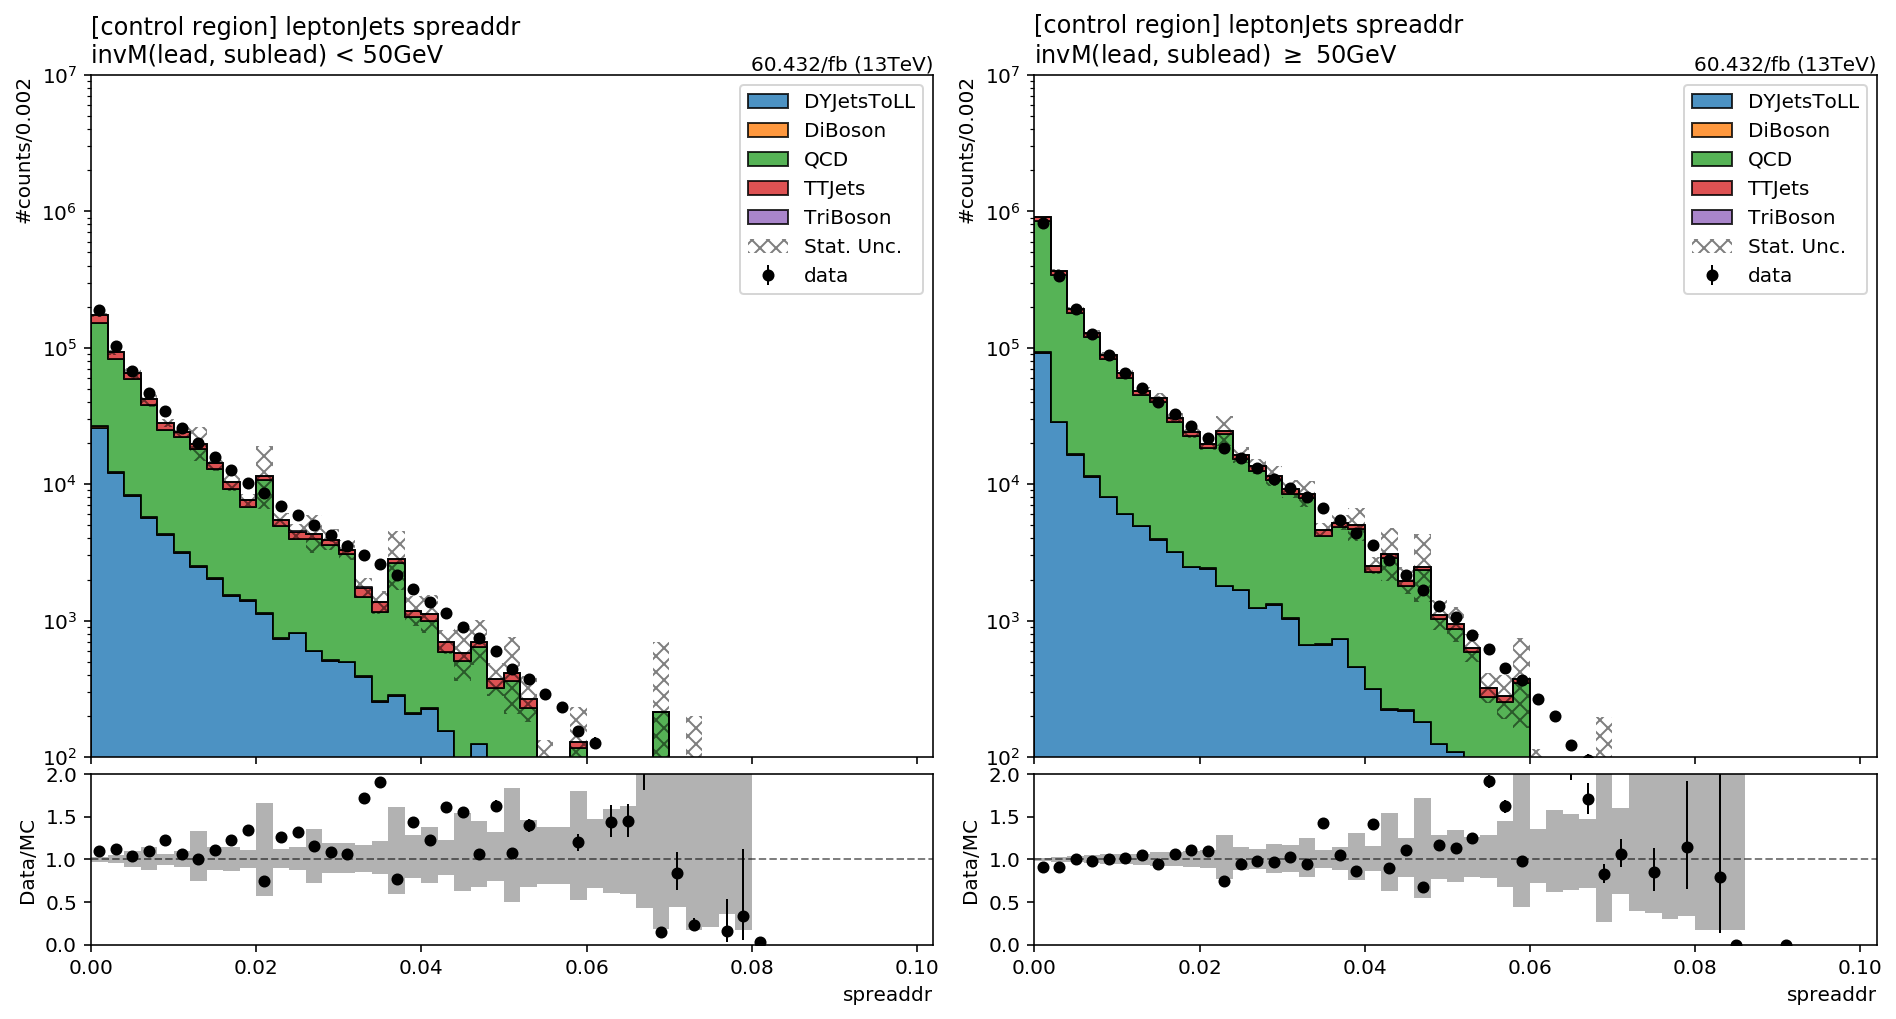

In [47]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['spreaddr_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['spreaddr_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['spreaddr_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['spreaddr_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['spreaddr_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e2, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets spreaddr\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets spreaddr\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

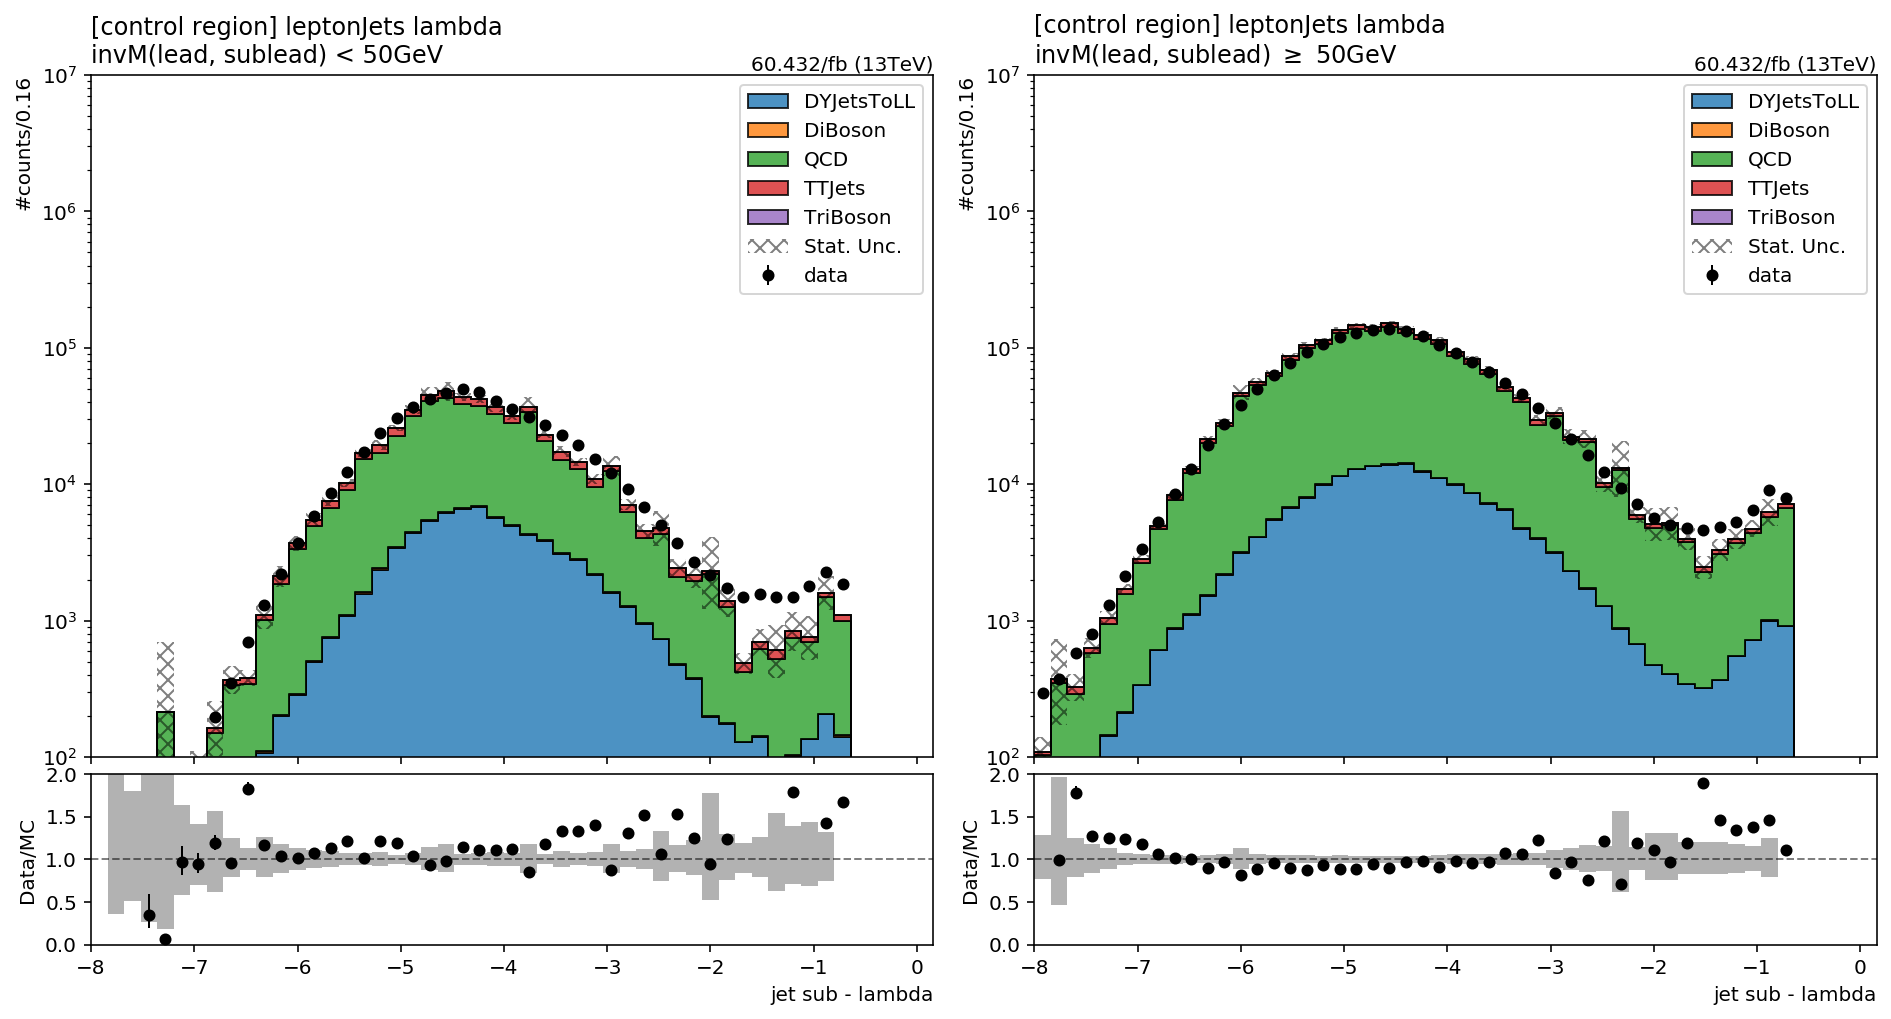

In [48]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['lamb_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['lamb_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['lamb_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['lamb_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['lamb_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e2, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets lambda\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets lambda\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

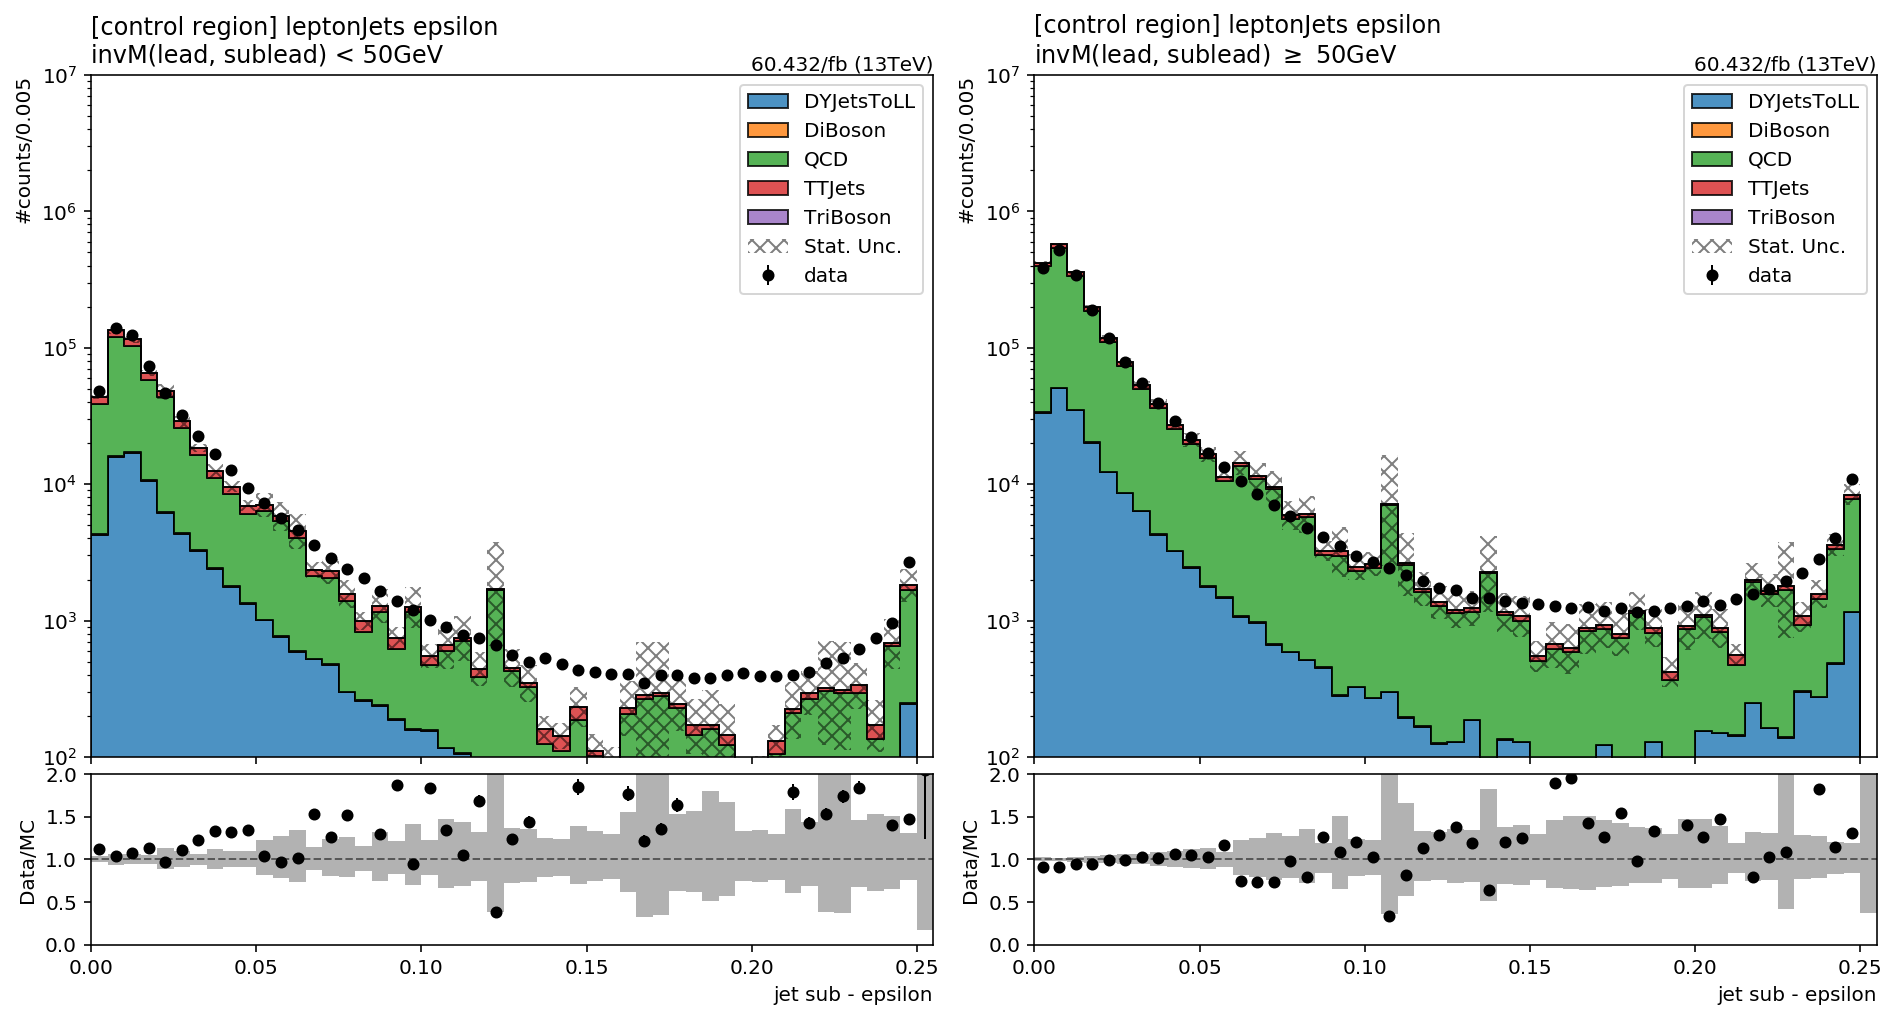

In [49]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['epsi_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['epsi_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['epsi_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['epsi_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['epsi_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e2, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets epsilon\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets epsilon\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

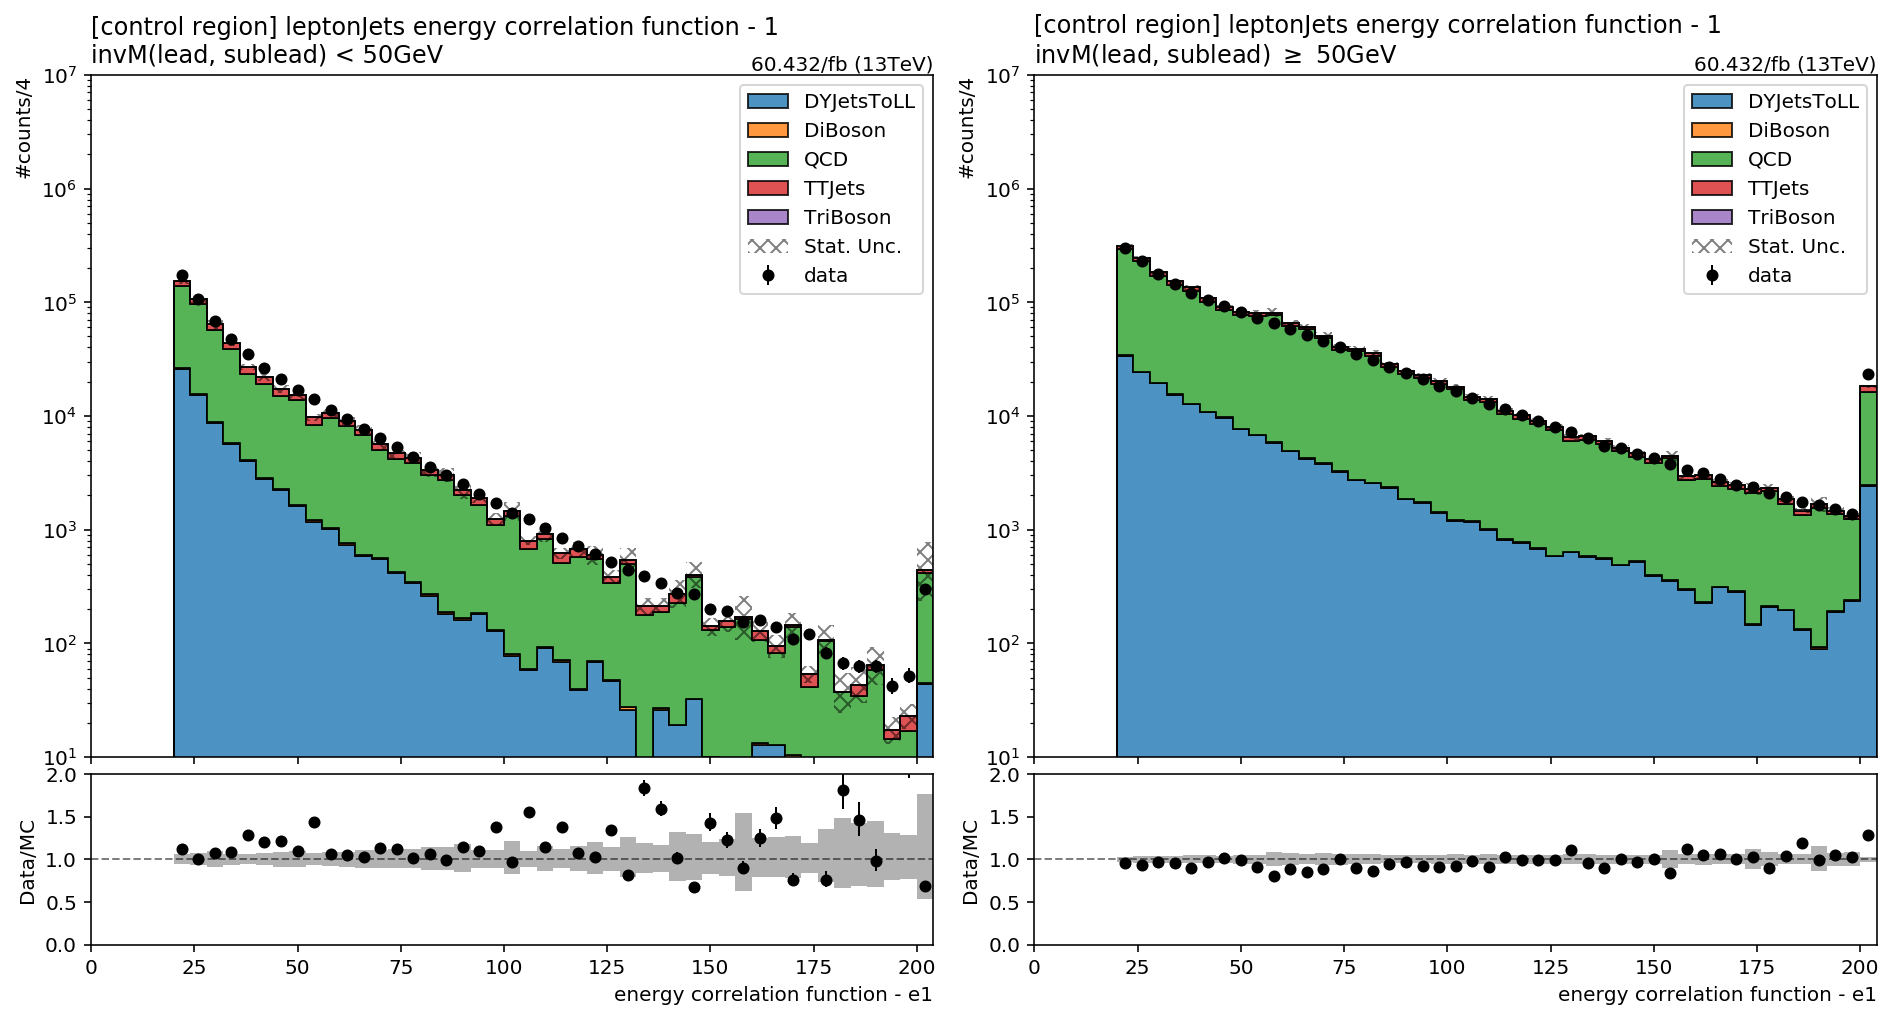

In [51]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['ecfe1_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['ecfe1_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['ecfe1_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['ecfe1_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['ecfe1_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets energy correlation function - 1\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets energy correlation function - 1\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

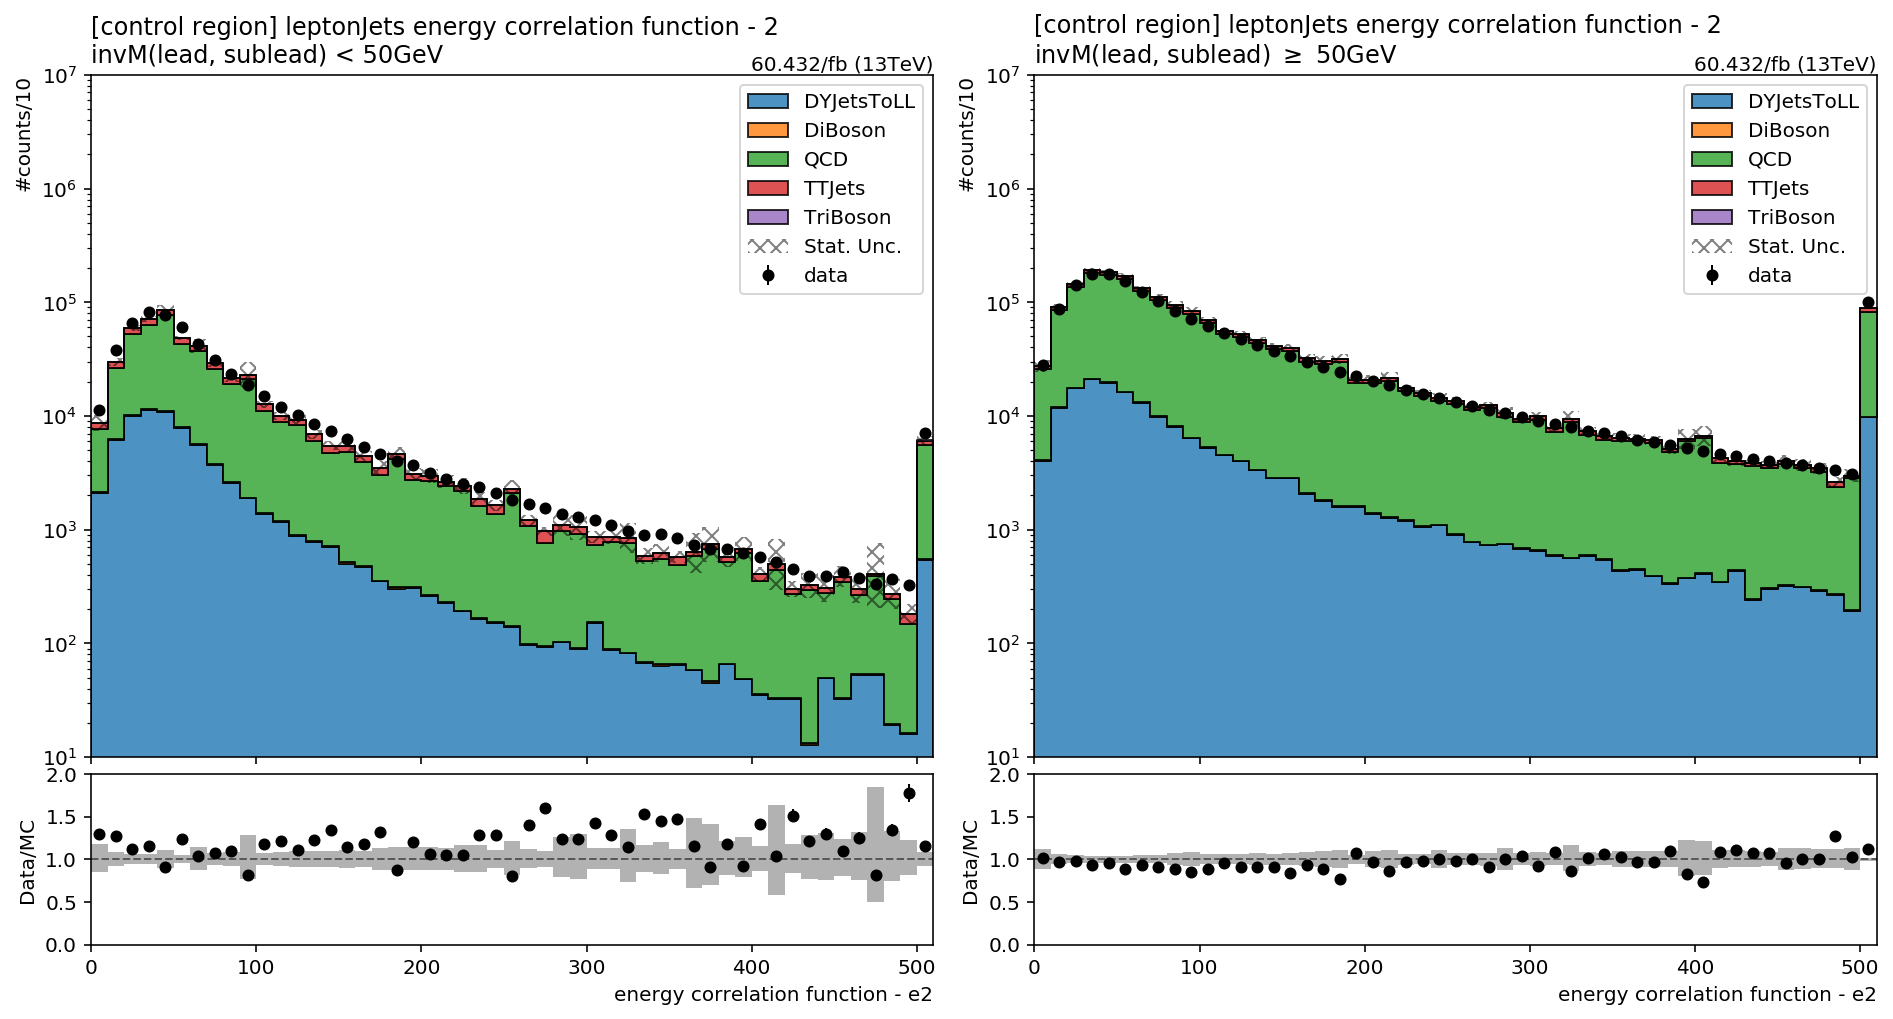

In [52]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['ecfe2_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['ecfe2_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['ecfe2_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['ecfe2_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['ecfe2_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets energy correlation function - 2\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets energy correlation function - 2\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

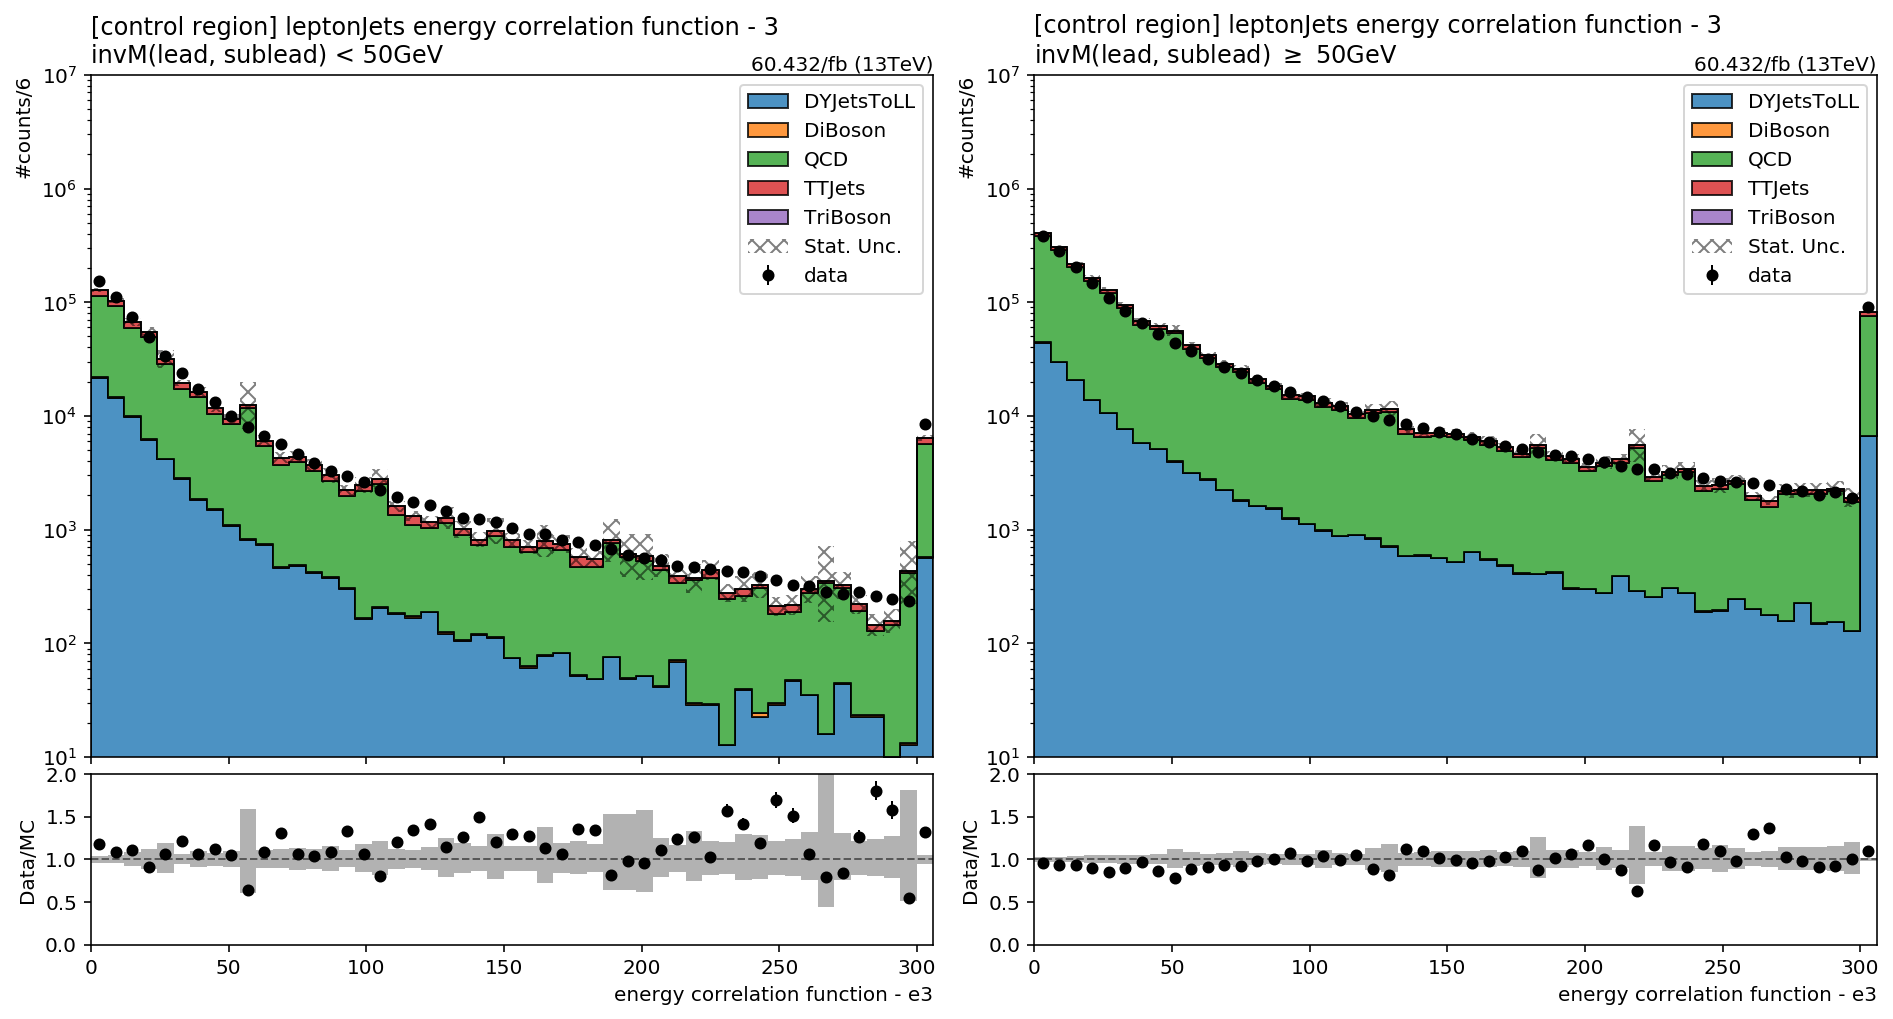

In [53]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['ecfe3_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['ecfe3_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['ecfe3_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['ecfe3_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['ecfe3_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets energy correlation function - 3\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets energy correlation function - 3\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

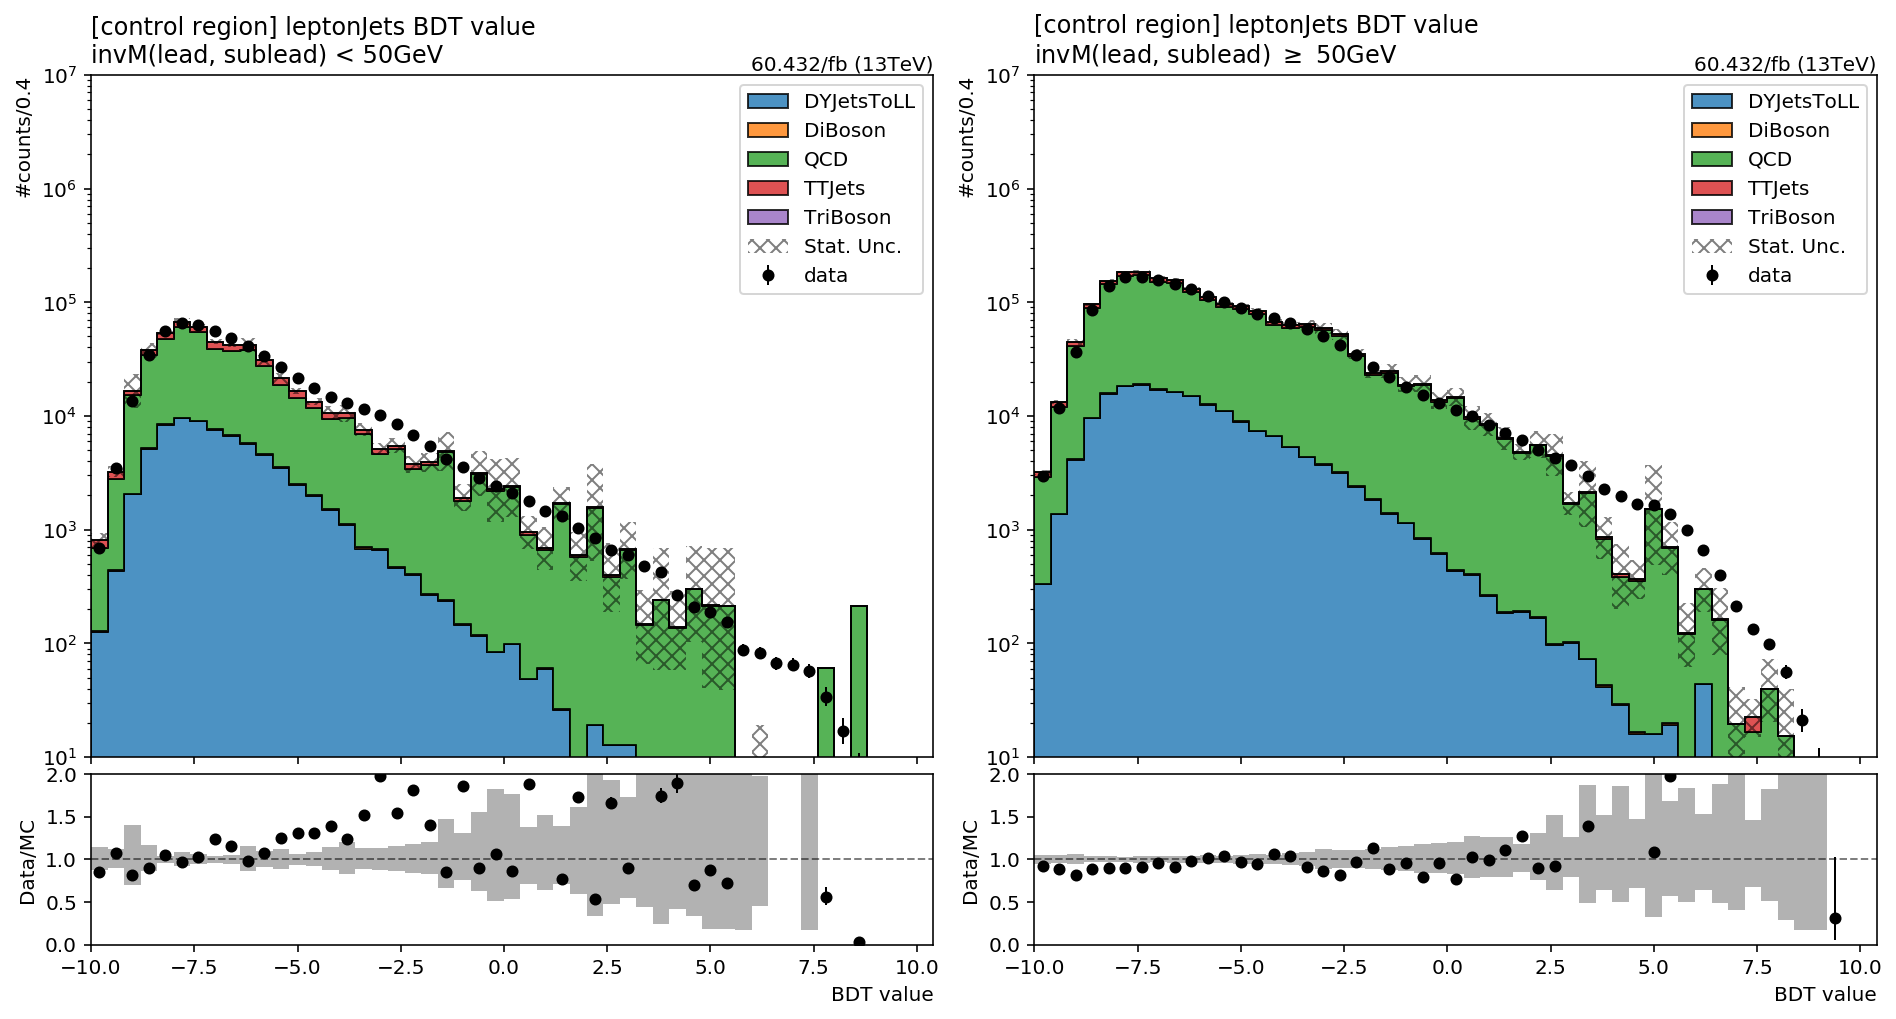

In [54]:
fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8),
                                  gridspec_kw={"height_ratios": (4, 1), "hspace": 0.04, "wspace": 0.12},
                                  sharex=True,)

ids=output['mva_cat'].identifiers('ms')
for i in range(len(ids)):
    hist.plot1d(output['mva_cat'][notdata].project('ms', ids[i]), overlay='cat', ax=axes[i],
               clear=False, stack=True, overflow='over',
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output['mva_cat']['data'].project('ms', ids[i]), overlay='cat', ax=axes[i],
               overflow='over', clear=False,
               error_opts=data_err_opts)

    hist.plotratio(output['mva_cat']['data'].project('ms', ids[i]).sum('cat'),
                   output['mva_cat'][notdata].project('ms', ids[i]).sum('cat'),
                   ax=raxes[i], overflow='over', unc='num',
                   error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})

for rax in raxes:
    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

for ax in axes:    
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim([1e1, 1e7])
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.legend()
    ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
    
axes[0].set_title('[control region] leptonJets BDT value\ninvM(lead, sublead) < 50GeV', x=0, ha='left')
axes[1].set_title('[control region] leptonJets BDT value\ninvM(lead, sublead) $\geq$ 50GeV', x=0, ha='left');

---